## Scatter Plot (Korea Mean SST & Precip, Nino3.4)

In [9]:
## Modules for Calculate netCDF 
import numpy    as np
import xarray   as xr
import netCDF4 
import pandas as pd

## Modules for caculating statistics
from scipy   import stats, signal
from sklearn import linear_model

## Modules for plottings
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap, shiftgrid

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

## Modules for modulating systems
import os
import warnings
warnings.filterwarnings('ignore')

#### <Read T2m & Precp station data over Korea

In [10]:
f = xr.open_dataset("./station.nc")
var1 = f['temp']
var2 = f['prcp']

## Read the Coordinates
time_year  = f['time'].dt.year # pandas: the year of the datetime
station_lon = f['station_lon'] # or f.station_lon
station_lat = f['station_lat']
station_num = f['station_number']

##Indexing(Numpy where function multiple conditions)
ind_year  = np.where((time_year>=1979) & (time_year<=2018))

t2m_station = var1[ind_year[0],:].mean("station_num")
prcp_station = var2[ind_year[0],:].mean("station_num")

In [11]:
## Remove trend 
p = t2m_station.polyfit(dim="time", deg=1)
fit = xr.polyval(t2m_station["time"], p.polyfit_coefficients)
dtrend_t2m = t2m_station - fit

## Calculate climatology and anomalies
clim_t2m = dtrend_t2m.groupby("time.month").mean()
t2m      = dtrend_t2m.groupby("time.month") - clim_t2m

##Calculate DJF 
t2m_season_all = t2m.where(t2m['time.season'] == "DJF")
t2m_season     = t2m_season_all.rolling(min_periods=3, center=True, time=3).mean()
t2m_season[0]  = t2m_season_all[0:2].mean()
t2m_season     = t2m_season.groupby('time.year').mean('time')

In [12]:
## Remove trend 
p = prcp_station.polyfit(dim="time", deg=1)
fit = xr.polyval(prcp_station["time"], p.polyfit_coefficients)
dtrend_prcp = prcp_station - fit

## Calculate climatology and anomalies
clim_prcp = dtrend_prcp.groupby("time.month").mean()
prcp      = dtrend_prcp.groupby("time.month") - clim_prcp

##Calculate DJF 
prcp_season_all = prcp.where(prcp['time.season'] == "DJF")
prcp_season     = prcp_season_all.rolling(min_periods=3, center=True, time=3).mean()
prcp_season[0]  = prcp_season_all[0:2].mean()
prcp_season     = prcp_season.groupby('time.year').mean('time')

In [13]:
f = xr.open_dataset("./DJF_nino34.nc")
nino34 = f["DJFnino34"]

In [16]:
var1  =  nino34[1::]
var2  =  t2m_season[1::]
var3  =  prcp_season[1::]

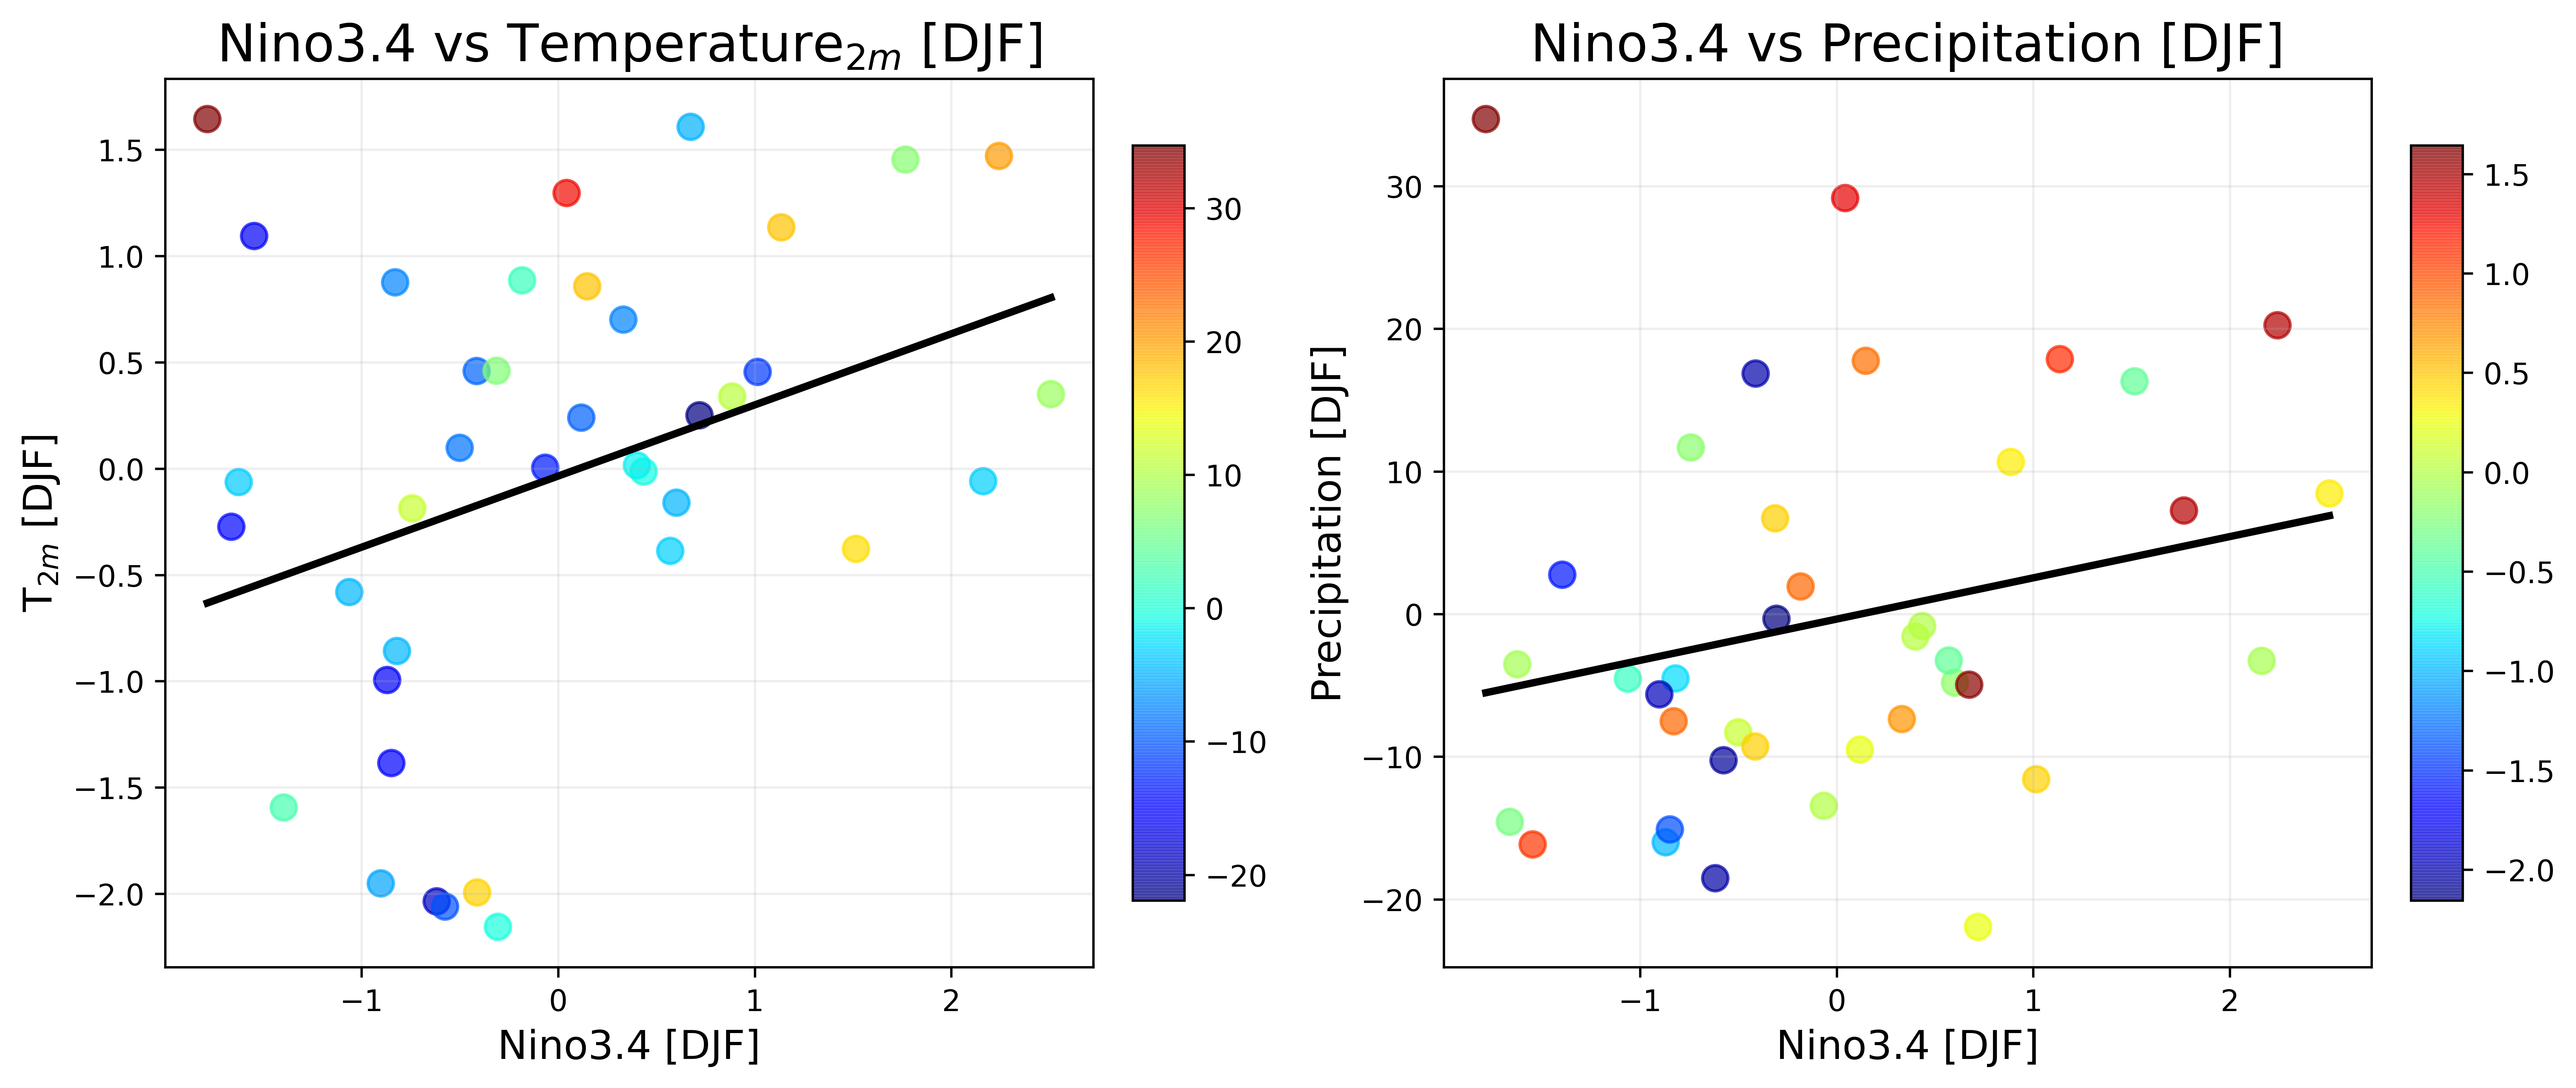

In [17]:
fig, axes = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)

## Plot Scatter plots between Nino3.4 & Mean temperature and precipitation
scat3 = axes[0].scatter(var1,var2,s=75,alpha=0.7,c=var3,cmap='jet')
scat4 = axes[1].scatter(var1,var3,s=75,alpha=0.7,c=var2,cmap='jet')

## Plot Regression lines between Nino3.4 & Mean temperature and precipitation
reg = linear_model.LinearRegression()
reg.fit(var1.values.reshape(-1,1),var2.values.reshape(-1,1))
xp = np.linspace(np.min(var1),np.max(var1),100)
yp = reg.coef_*xp + reg.intercept_
axes[0].plot(xp,yp.T,color='k',linewidth=2.5)

reg = linear_model.LinearRegression()
reg.fit(var1.values.reshape(-1,1),var3.values.reshape(-1,1))
xp = np.linspace(np.min(var1),np.max(var1),100)
yp = reg.coef_*xp + reg.intercept_
axes[1].plot(xp,yp.T,color='k',linewidth=2.5)


## Detail plot properties
cbar2 = fig.colorbar(scat3, location = 'right', ax = axes[0], 
                    shrink = 0.85, aspect = 35, pad = 0.02 )
cbar3 = fig.colorbar(scat4, location = 'right', ax = axes[1], 
                    shrink = 0.85, aspect = 35, pad = 0.02 )
for ind_plot in range(2): 
    axes[ind_plot].grid(alpha=0.2)
    axes[ind_plot].set_xlabel("Nino3.4 [DJF]",fontsize=13.5)
    
axes[0].set_ylabel("T$_{2m}$ [DJF]",fontsize=13.5)    
axes[1].set_ylabel("Precipitation [DJF]",fontsize=13.5)    

axes[0].set_title("Nino3.4 vs Temperature$_{2m}$ [DJF]",fontsize=17.5)
axes[1].set_title("Nino3.4 vs Precipitation [DJF]",fontsize=17.5)


## <Save Time Series Figure to RESULT directory
dir_name   =  "./"
file_name  =  "Scat_mean_Nino34_t2m_prcp.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)